## Exploring different algorithms for predictive modelling
- Aim 1: Predicting track deteriation over time. Similar to engineers' workflow of using standard deviation, is there a better auto-regressive method to explore TRC data? Can integrating other data sources help?

- Aim 2: Predicting work orders / catastrophic failure (requires C195, C138 TRC data)

- Aim 3: Predicting work order types -- can features predict work order type? (requires C195, C138 TRC data)

- Aim 4: predicting the cost of work orders (requires C195, C138 TRC data)

### Aim A: Predicting Track deteoriation over time (TRC data)
Using the TRC data from 2017, can we reliably find significant dips in quality over time? 

In [1]:
import os
from utils import paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from to_gps_coords import *

In [2]:
## Step 1: load data, join them according to track location. 
### Best to align in lower resolution, since some misalignment visible from heatmaps
os.listdir(paths.TRC)

['531401 - DM A 0-9.69 NORTHGATE-SANDGATE-201701311116.csv',
 '531401 - DM A 0-9.69 NORTHGATE-SANDGATE-201707041300.csv',
 '531401 - DM A 0-9.69 NORTHGATE-SANDGATE-201710171136.csv',
 '531401 - DM A 0-9.69 NORTHGATE-SANDGATE-201801311009.csv']

## Problem 1: aligning TRC data
#### Approach 1: Moving averages to smooth data out

In [3]:
## function to explore different moving averages

def set_ma(ma):
    dates = ['2017_01', '2017_07', '2017_10', '2018_01']
    cols = ['METRAGE', 'GAUGE', 'SUPER', 'TOPL', 'TOPR', 'TW10', 'TW3', 'VERL',
           'VERR', 'CONF', 'GRHT', 'VOLT', 'TRST', 'OVHT', 'ACLN', 'ACVT', 'Date']
    df = pd.DataFrame(columns = cols)

    for i, f in enumerate(os.listdir(paths.TRC)):
        df_t = pd.read_csv(os.path.join(paths.TRC, f), skiprows = 4)
        df_t.columns = [x.replace(' ','') for x in list(df_t.columns)]
        df_t= df_t.drop('', axis = 1).dropna()

        ## moving average to smooth out the discrepancies: window size = ma
        df_t.iloc[:, 1:-1] = df_t.iloc[:,1:-1].rolling(window=ma).mean()
        df_t['Date'] = dates[i]
        df = pd.concat([df, df_t]) 

    ## pivot data
    long_df = pd.DataFrame(df.set_index(['Date', 'METRAGE']).stack()).reset_index()
    long_df.columns = ['Date','METRAGE','Measure', 'Value']
    temp = long_df.set_index(['Measure','METRAGE','Date'])
    df_wide = temp.loc[~temp.index.duplicated(keep='first')].unstack('Date')
    df_wide.columns = df_wide.columns.droplevel(0)
    df_wide = df_wide.reset_index()
    return df_wide.set_index('METRAGE')

def plot_heatmap(df_wide, measure, r1,r2):
    fig, ax = plt.subplots(figsize = (20,5))
    ax = sns.heatmap(df_wide[df_wide['Measure']==measure].iloc[r1:r2, 1:].as_matrix().T, cmap = 'Oranges')

In [4]:
def ma_plot(ma, measure, r1, r2):
    df = set_ma(ma)
    plot_heatmap(df, measure, r1, r2 )


#### Moving averages do not smooth out mis-alignment

**** We can see from the following MA of 1 (no moving average), 5, and 20, the precision lowers, but the mis-alignment still exits ****

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


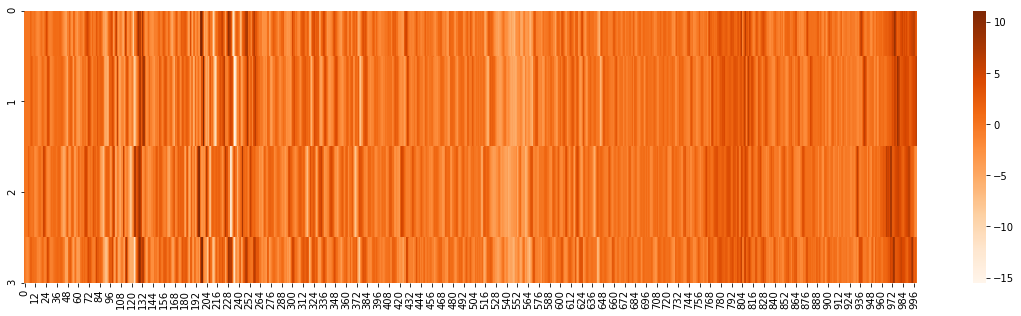

In [5]:
ma_plot(1, 'TW3', 0, 1000)

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


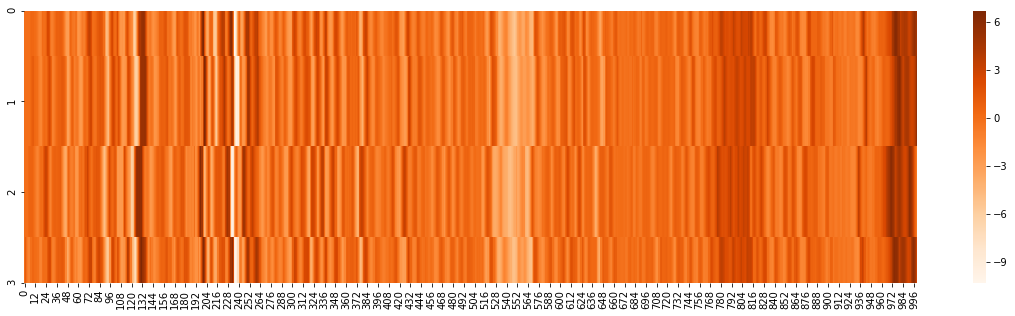

In [6]:
ma_plot(5, 'TW3', 0, 1000)

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


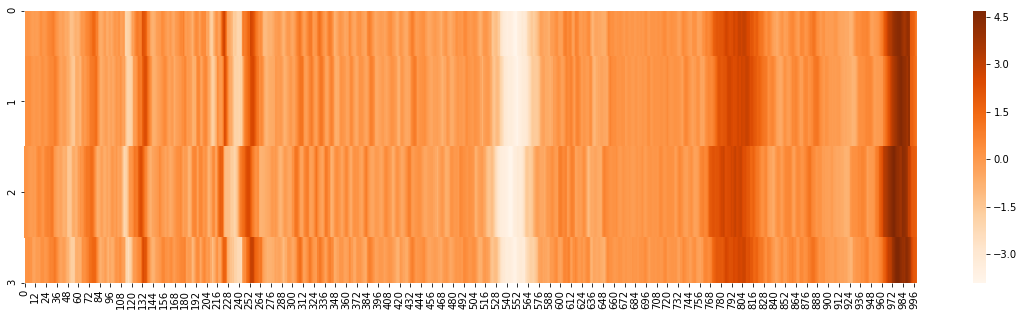

In [7]:
ma_plot(20, 'TW3', 0, 1000)

#### Approach 2: sequence alignment
- let's sample the first 1000 points on the TW3 and try to align them by minimising differences in the first 1000 rows. 
    - offset reference (date == 2017_01) by 20 point 20 to 1020 so there is some room to play with in sliding other range back by 20
    - Compute difference between the values
    - find the minimum standard deviation in the differences

- We can check accuracy of this alignment using all other measures


In [9]:
wide_df = set_ma(1)

In [10]:
##restrict sample
s_df = wide_df[wide_df['Measure']=='TW3'].iloc[:1100, :].reset_index()

In [11]:
def align_TRC(s_df, date1, date2):
    counts = []
    for i in range(100):
        diff1 = s_df[date1][20:1020] - s_df[date2][i:1000+i].values
        ans = np.std(diff1[~np.isnan(diff1)])
        counts.append(ans)
    min_std = np.argmin(np.array(counts))
    print('To align: exclude first {1} rows of {0} data \nhere is a plot of TW3'.format(date2, min_std-20))
    t = np.array([s_df[date1][20:1020].values, s_df[date2][min_std:1000+min_std].values])
    fig, ax = plt.subplots(figsize = (20,5))
    ax = sns.heatmap(t, cmap = 'Oranges')

To align: exclude first 2 rows of 2017_07 data 
here is a plot of TW3


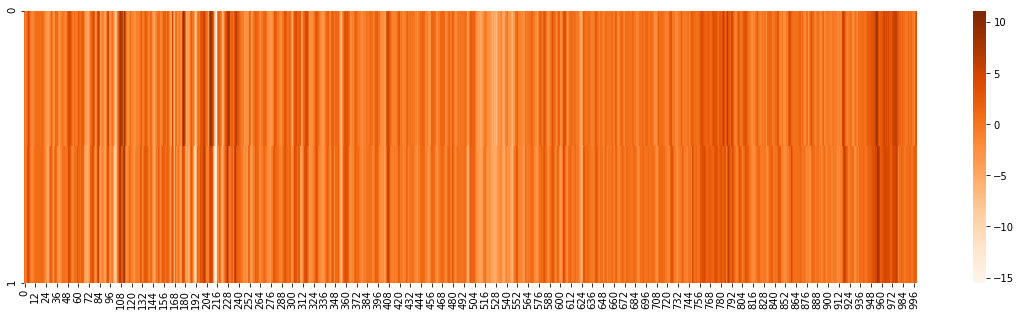

In [12]:
align_TRC(s_df, '2017_01','2017_07')

To align: exclude first -4 rows of 2017_10 data 
here is a plot of TW3


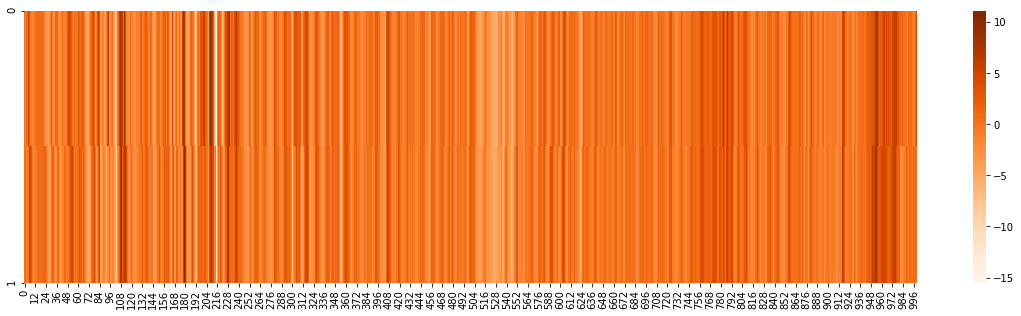

In [13]:
align_TRC(s_df, '2017_01','2017_10')

To align: exclude first 0 rows of 2018_01 data 
here is a plot of TW3


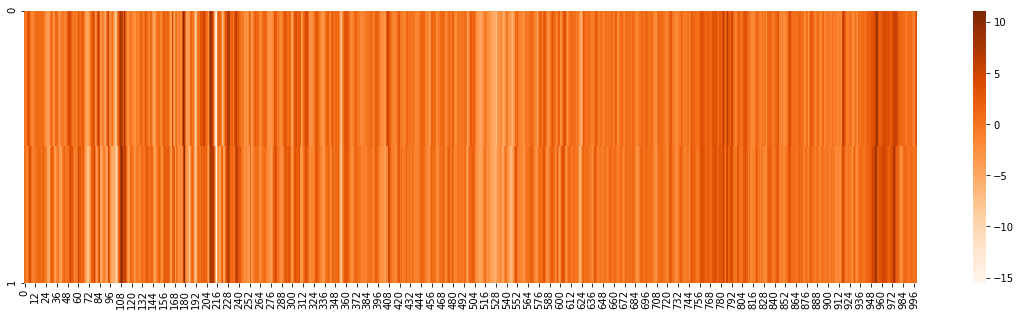

In [14]:
align_TRC(s_df, '2017_01','2018_01')

In [15]:
## try with topL
a_df = wide_df[wide_df['Measure']=='TOPL'].iloc[:1100, :].reset_index()

To align: exclude first 3 rows of 2018_01 data 
here is a plot of TW3


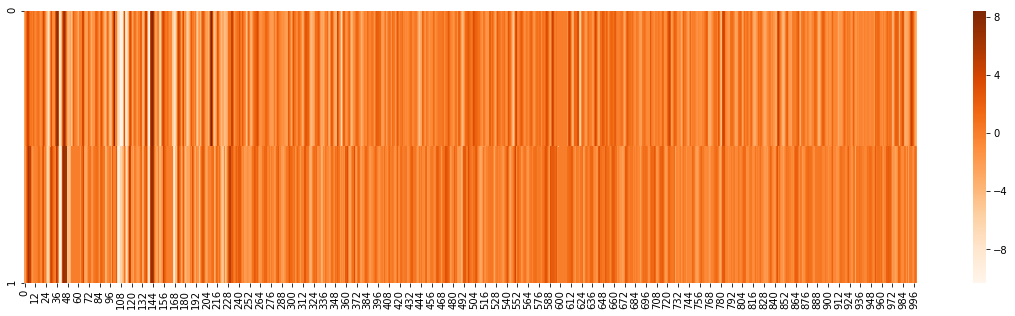

In [16]:
align_TRC(a_df, '2017_01','2018_01')

To align: exclude first -3 rows of 2017_10 data 
here is a plot of TW3


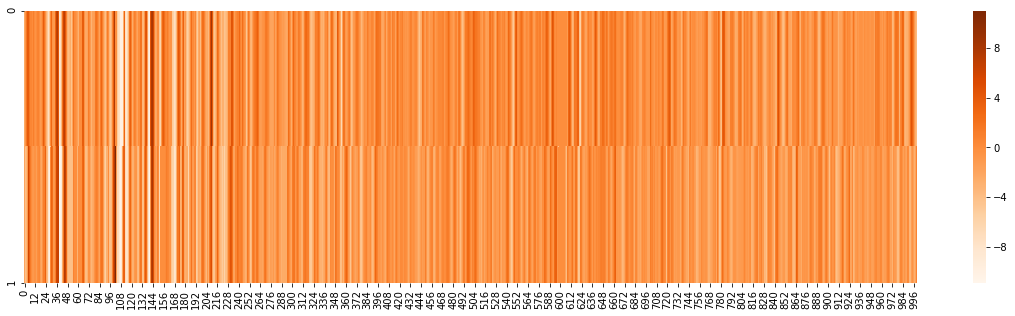

In [17]:
align_TRC(a_df, '2017_01','2017_10')

To align: exclude first 2 rows of 2017_07 data 
here is a plot of TW3


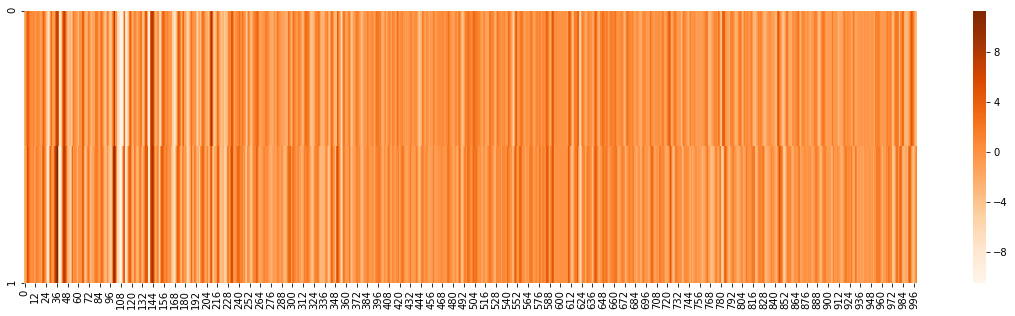

In [18]:
align_TRC(a_df, '2017_01','2017_07')

In [3]:
## scan all, report the mode for alignment
def align_TRC_all(s_df, date1, date2):
    measures = ['GAUGE', 'SUPER']
    meas_min = dict()
    
    for m in measures:
        counts = []
        for i in range(100):
            diff1 = s_df[s_df['Measure']== m][date1][20:1020] - s_df[s_df['Measure']==m][date2][i:1000+i].values
            ans = np.std(diff1[~np.isnan(diff1)])
            counts.append(ans)
        #print(counts)
        min_std = np.argmin(np.array(counts))
        meas_min[m]=min_std-20
    print(meas_min)
    g = list(meas_min.values())
    rec = round(mean(g))
    print('recommended:shift {0} by {1} compared to {2} '.format(date2, rec, date1))
    
#     t = np.array([s_df[date1][20:1020].values, s_df[date2][min_std:1000+min_std].values])
#     fig, ax = plt.subplots(figsize = (20,5))
#     ax = sns.heatmap(t, cmap = 'Oranges')

In [20]:
align_TRC_all(wide_df.reset_index(), '2017_01','2017_07')

{'GAUGE': 2, 'SUPER': 2, 'TOPL': 2, 'TOPR': 2, 'TW10': 2, 'TW3': 2, 'VERL': 2, 'VERR': 2, 'CONF': 3, 'GRHT': 2, 'VOLT': 1, 'TRST': 2, 'OVHT': 2, 'ACLN': 2, 'ACVT': 2}
recommended:shift 2017_07 by 2 compared to 2017_01 


In [21]:
align_TRC_all(wide_df.reset_index(), '2017_01','2017_10')

{'GAUGE': -3, 'SUPER': -4, 'TOPL': -3, 'TOPR': -3, 'TW10': -4, 'TW3': -4, 'VERL': -3, 'VERR': -4, 'CONF': -5, 'GRHT': -4, 'VOLT': -6, 'TRST': -4, 'OVHT': -3, 'ACLN': -2, 'ACVT': -5}
recommended:shift 2017_10 by -4 compared to 2017_01 


In [22]:
align_TRC_all(wide_df.reset_index(), '2017_10','2018_01') 
## align from oct 2017 instead, since it is really different from jan 2017

{'GAUGE': 4, 'SUPER': 4, 'TOPL': 6, 'TOPR': 6, 'TW10': 4, 'TW3': 4, 'VERL': 4, 'VERR': 4, 'CONF': 14, 'GRHT': 14, 'VOLT': 14, 'TRST': 12, 'OVHT': 14, 'ACLN': 14, 'ACVT': 14}
recommended:shift 2018_01 by 4 compared to 2017_10 


In [24]:
## shift dataset
temp = wide_df.reset_index()
temp['2017_07'] = temp.groupby('Measure')['2017_07'].shift(-2)
temp['2017_10'] = temp.groupby('Measure')['2017_10'].shift(4)

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


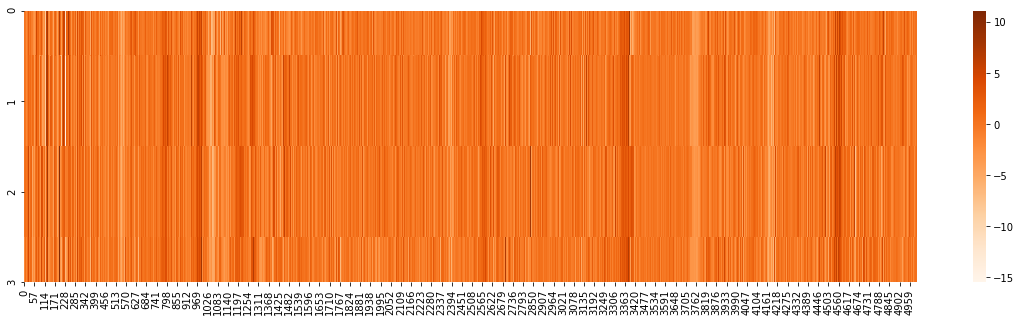

In [25]:
## plot
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(temp[temp['Measure']=='TW3'].iloc[0:5000, 2:].as_matrix().T, cmap = 'Oranges')

In [26]:
## try to apply MA on top of the adjusted dataset
df_new_ma = temp.dropna().groupby('Measure').rolling(10).mean().reset_index()

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


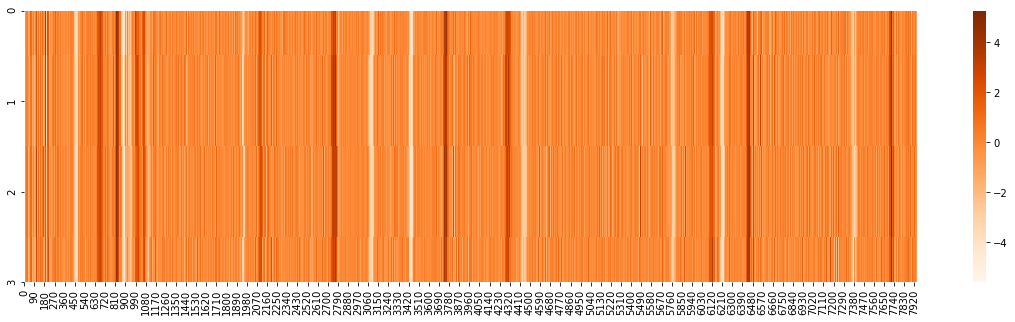

In [27]:
dates = ['2017_01', '2017_07', '2017_10', '2018_01']
fig, ax = plt.subplots(figsize = (20,5))
ax = sns.heatmap(df_new_ma[df_new_ma['Measure']=='TW3'][dates].iloc[0:9000,].as_matrix().T, cmap = 'Oranges')


In [28]:
df_ma10 = df_new_ma.rename(columns={'level_1':'old_index'})

In [29]:
df_ma10.to_csv('aligned_10MA_TRC.csv')

In [30]:
## MA5
ma_5 = temp.dropna().groupby('Measure').rolling(5).mean().reset_index()
ma_5= ma_5.rename(columns={'level_1':'old_index'})

In [32]:
ma_5.to_csv('ma_5.csv')

In [31]:
#noma
no_ma_adjusted= temp.dropna().reset_index().rename(columns={'level_1':'old_index'})

In [33]:
no_ma_adjusted.to_csv('TRC_adjusted.csv', index = False)

### Automating this process

In [2]:
fl= os.listdir(paths.TRC_195)[1:-2]

In [6]:
## general pattern of files
## trackID - station1 to station2 - datecar - formatted.csv

filedf = [] 

for f in fl:
    ans = dict()
    br = f.split('-')[:-1]
    ans['Track_ID']= br[0].replace(' ', '')
    ans['Description'] = '-'.join(br[1:-2])
    ans['Date'] = br[-1].replace(' ', '')[:8]
    ans['Recording_car']= br[-1].replace(' ','')[8:]
    ans['filename'] = f
    filedf.append(ans)
    

In [7]:
f_df = pd.DataFrame(filedf)

In [8]:
a = f_df[['Track_ID', 'Date','Recording_car']].groupby(['Track_ID','Date']).count()

In [9]:
# add previously combined data
c_files = []
cfiles = os.listdir(os.path.join(paths.TRC_195, 'combined'))
for f in cfiles:
    Track_ID = f.split('_')[0]
    Date = f.split('_')[1].split('.')[0]
    a = {'Track_ID': Track_ID, 'Description' : '', 'Date': Date, 'Recording_car':'', 'filename': f}
    c_files.append(a)

In [10]:
file_df = pd.concat([f_df, pd.DataFrame(c_files)])

In [11]:
file_df

,Track_ID,Description,Date,Recording_car,filename
0,726001,SA 207-251.12 T BINE,20171102,1049,726001 - SA 207-251.12 T BINE-MUNGAR - 2017110...
1,726001,SA 207-251.12 THEEBINE,20160619,1430,726001 - SA 207-251.12 THEEBINE - MUNGAR - 201...
2,726001,SA 207,20170411,1536,726001 - SA 207-251.12 THEEBINE TO MUNGAR - 20...
3,726001,SA 207,20170829,1459,726001 - SA 207-251.12 THEEBINE TO MUNGAR - 20...
4,726001,SA 207-251.12 THEEBINE,20140224,1412,726001 - SA 207-251.12 THEEBINE-MUNGAR - 20140...
...,...,...,...,...,...
77,729001,SD 307.87-277.48 BUNDABERG,20180613,1204,729001 - SD 307.87-277.48 BUNDABERG-COLTON PAR...
0,726001,,20170621,,726001_20170621.csv
1,727001,,20170621,,727001_20170621.csv
2,729001,,20170621,,729001_20170621.csv


In [12]:
## transiently transfer the additional files to TRC_195 folder for this
def read_files(file_df):
    final_df = dict()
    unique_track_id = file_df['Track_ID'].unique()
    for ind in unique_track_id:
        total = []
        # iterate through files one track id at a time
        for i, file in file_df[file_df['Track_ID']== ind].iterrows():
            df = pd.read_csv(os.path.join(paths.TRC_195, file['filename']))
            df['Date'] = file['Date'] #assign date
            total.append(df)
        total_df = pd.concat(total)
        ## now reshape the table
        long_df = pd.DataFrame(total_df.set_index(['Date','METRAGE']).stack()).reset_index()
        long_df.columns = ['Date', 'METRAGE', 'Measure','Value']
        temp = long_df.set_index(['Measure','METRAGE','Date'])
        df_wide = temp.loc[~temp.index.duplicated(keep='first')].unstack('Date')
        df_wide.columns = df_wide.columns.droplevel(0)
        df_wide = df_wide.reset_index()
        final_df[ind] = df_wide.set_index('METRAGE')
    return final_df

In [13]:
total_df = read_files(file_df)

In [14]:
unique_track_id = file_df['Track_ID'].unique()

In [15]:
unique_track_id

array(['726001', '727001', '728001', '729001'], dtype=object)

In [16]:
for key, table in total_df.items():
    table.reset_index().to_csv('{}.csv'.format(key), index = False)

In [27]:
def align_TRC_all(s_df, date1, date2):
    print('Comparing {0} with {1}'.format(date1, date2))
    measures = ['GAUGE', 'SUPER']
    meas_min = dict()
    
    for m in measures:
        #print('Looking at measure: {0}'.format(m))
        counts = []
        temp_df = s_df[s_df['Measure']== m][[date1, date2]]
        #print(temp_df.shape)
        for i in range(100):
            val1 = temp_df.iloc[1000:-1000:][date1].values 
            val2 = temp_df.iloc[950+i:-1050+i, :][date2].values
            diff1 = val1 - val2
            ans = np.std(diff1[~np.isnan(diff1)])
            counts.append(ans)
        min_std = np.argmin(np.array(counts))
        meas_min[m]=min_std-50
    g = list(meas_min.values())
    
    rec = round(sum(g)/len(g)) # return the mode of alignment
    print('recommended:shift {0} by {1} compared to {2} '.format(date2, rec, date1))
    return rec

In [18]:
def shift_TRC(df, date, shift_value):
    return df.groupby('Measure')[date].shift(shift_value)


In [19]:
def fill_method(col, nrow):
    try:
        ans = (col.fillna(method = 'ffill', limit = nrow) + col.fillna(method= 'bfill', limit = nrow))/(nrow*2)
    except: ## too many missing values
        ans = np.nan
    return ans

In [20]:
def align_TRC_main(data_raw):
    ## takes a list of dataframes and aligns them
    data =  data_raw.groupby('Measure').transform(lambda x: x.fillna(x.mean())) ## fill NA values with mean val
    
    data['Measure'] = data_raw['Measure']
    dates = [date for date in data.columns.tolist() if date !='Measure' and date != 'METRAGE'] # get a list of dates
    ans = {'METRAGE' : data['METRAGE'].values,
               'Measure': data['Measure'].values}
    r = len(dates)
    offset = [0]
    
    for i in range(1,r):
        
        rec = align_TRC_all(data, dates[i-1], dates[i])
        offset.append(rec)
    to_offset = [sum(offset[:ind+1]) for ind, val in enumerate(offset)]
    print(offset)
    print(to_offset)
    # offset all
    ## first define actual dataset to shift
    
    for ind, offset_by in enumerate(to_offset):
        print(dates[ind], offset_by)
        x = shift_TRC(data_raw, dates[ind], offset_by)
        ans[dates[ind]] = x
    ans_shifted = pd.DataFrame(ans).groupby('Measure').transform(lambda x: x.fillna(fill_method(x, 3)))
    ans_shifted['Measure'] = data_raw['Measure']
    return ans_shifted

In [21]:
## calculating missing data in TRC

In [33]:
df_726001 = pd.read_csv(os.path.join('726001.csv'))
ans = []
for col in df_726001.columns:
    ans.append(len(df_726001[df_726001[col].isna()]) / len(df_726001) *100)

In [14]:
sum(ans)/len(ans)

23.676107950240393

In [15]:
df_726001 = pd.read_csv(os.path.join('727001.csv'))
ans = []
for col in df_726001.columns:
    ans.append(len(df_726001[df_726001[col].isna()]) / len(df_726001) *100)
sum(ans)/len(ans)

14.573598524124373

In [28]:
df_726001 = pd.read_csv(os.path.join('728001.csv'))
df_726001 = df_726001[df_726001['METRAGE']< 277.475] ## something odd with 20190305 data collecting beyond 277.475
ans = []

for col in df_726001.columns:
    ans.append(len(df_726001[df_726001[col].isna()]) / len(df_726001) *100)
sum(ans)/len(ans)

10.258063489031107

In [27]:
df_726001 = pd.read_csv(os.path.join('729001.csv'))

ans = []
for col in df_726001.columns:
    ans.append(len(df_726001[df_726001[col].isna()]) / len(df_726001) *100)
sum(ans)/len(ans)

21.427330181496703

In [29]:
(23.676107950240393+14.573598524124373+10.258063489031107+21.427330181496703)/4

17.483775036223143

In [30]:
## Align dataset

In [28]:
df_726001 = pd.read_csv(os.path.join('726001.csv'))
new_726001 = align_TRC_main(df_726001)

Comparing 20140224 with 20140623
recommended:shift 20140623 by 0.0 compared to 20140224 
Comparing 20140623 with 20141004
recommended:shift 20141004 by 0.0 compared to 20140623 
Comparing 20141004 with 20141202
recommended:shift 20141202 by 0.0 compared to 20141004 
Comparing 20141202 with 20150228
recommended:shift 20150228 by 0.0 compared to 20141202 
Comparing 20150228 with 20150616
recommended:shift 20150616 by 0.0 compared to 20150228 
Comparing 20150616 with 20150811
recommended:shift 20150811 by 0.0 compared to 20150616 
Comparing 20150811 with 20160229
recommended:shift 20160229 by 0.0 compared to 20150811 
Comparing 20160229 with 20160619
recommended:shift 20160619 by 0.0 compared to 20160229 
Comparing 20160619 with 20160909
recommended:shift 20160909 by 0.0 compared to 20160619 
Comparing 20160909 with 20161026
recommended:shift 20161026 by 0.0 compared to 20160909 
Comparing 20161026 with 20170411
recommended:shift 20170411 by 0.0 compared to 20161026 
Comparing 20170411 wi

In [29]:
df_727001 = pd.read_csv(os.path.join('727001.csv'))
new_727001 = align_TRC_main(df_727001)

Comparing 20140224 with 20140623
recommended:shift 20140623 by 0.0 compared to 20140224 
Comparing 20140623 with 20141003
recommended:shift 20141003 by -19.0 compared to 20140623 
Comparing 20141003 with 20141202
recommended:shift 20141202 by 0.0 compared to 20141003 
Comparing 20141202 with 20150228
recommended:shift 20150228 by 0.0 compared to 20141202 
Comparing 20150228 with 20150616
recommended:shift 20150616 by 0.0 compared to 20150228 
Comparing 20150616 with 20150811
recommended:shift 20150811 by 0.0 compared to 20150616 
Comparing 20150811 with 20151130
recommended:shift 20151130 by 0.0 compared to 20150811 
Comparing 20151130 with 20160229
recommended:shift 20160229 by 0.0 compared to 20151130 
Comparing 20160229 with 20160908
recommended:shift 20160908 by -19.0 compared to 20160229 
Comparing 20160908 with 20161026
recommended:shift 20161026 by 0.0 compared to 20160908 
Comparing 20161026 with 20170411
recommended:shift 20170411 by 0.0 compared to 20161026 
Comparing 2017041

In [30]:
df_728001 = pd.read_csv('728001.csv')
new_728001 = align_TRC_main(df_728001)

Comparing 20140225 with 20140624
recommended:shift 20140624 by 0.0 compared to 20140225 
Comparing 20140624 with 20141003
recommended:shift 20141003 by -33.0 compared to 20140624 
Comparing 20141003 with 20141203
recommended:shift 20141203 by 28.0 compared to 20141003 
Comparing 20141203 with 20150228
recommended:shift 20150228 by -8.0 compared to 20141203 
Comparing 20150228 with 20150617
recommended:shift 20150617 by 0.0 compared to 20150228 
Comparing 20150617 with 20150812
recommended:shift 20150812 by 0.0 compared to 20150617 
Comparing 20150812 with 20151201
recommended:shift 20151201 by -1.0 compared to 20150812 
Comparing 20151201 with 20160301
recommended:shift 20160301 by 3.0 compared to 20151201 
Comparing 20160301 with 20160620
recommended:shift 20160620 by -0.0 compared to 20160301 
Comparing 20160620 with 20160908
recommended:shift 20160908 by -28.0 compared to 20160620 
Comparing 20160908 with 20161026
recommended:shift 20161026 by 27.0 compared to 20160908 
Comparing 20

In [31]:
df_729001 = pd.read_csv('729001.csv')
new_729001 = align_TRC_main(df_729001).reset_index()

Comparing 20140225 with 20140624
recommended:shift 20140624 by 0.0 compared to 20140225 
Comparing 20140624 with 20141203
recommended:shift 20141203 by 0.0 compared to 20140624 
Comparing 20141203 with 20150228
recommended:shift 20150228 by 0.0 compared to 20141203 
Comparing 20150228 with 20150617
recommended:shift 20150617 by 0.0 compared to 20150228 
Comparing 20150617 with 20150812
recommended:shift 20150812 by 0.0 compared to 20150617 
Comparing 20150812 with 20151201
recommended:shift 20151201 by 0.0 compared to 20150812 
Comparing 20151201 with 20160301
recommended:shift 20160301 by 0.0 compared to 20151201 
Comparing 20160301 with 20160620
recommended:shift 20160620 by 0.0 compared to 20160301 
Comparing 20160620 with 20160908
recommended:shift 20160908 by 0.0 compared to 20160620 
Comparing 20160908 with 20161026
recommended:shift 20161026 by 0.0 compared to 20160908 
Comparing 20161026 with 20170412
recommended:shift 20170412 by 0.0 compared to 20161026 
Comparing 20170412 wi

In [32]:
new_726001.to_csv('aligned_726001.csv', index = False)

In [33]:
new_729001.to_csv('aligned_729001.csv', index = False)

In [34]:
new_728001.to_csv('aligned_728001.csv', index = False)

In [35]:
new_727001.to_csv('aligned_727001.csv', index = False)

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


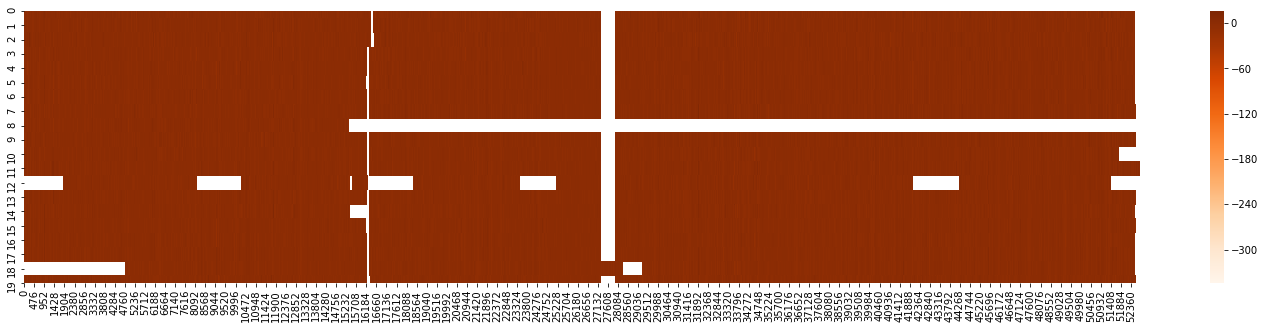

In [36]:
fig, ax = plt.subplots(figsize = (25,5))
ax = sns.heatmap(df_726001[df_726001['Measure']=='TW 3'].iloc[:, 2:].as_matrix().T, cmap = 'Oranges')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


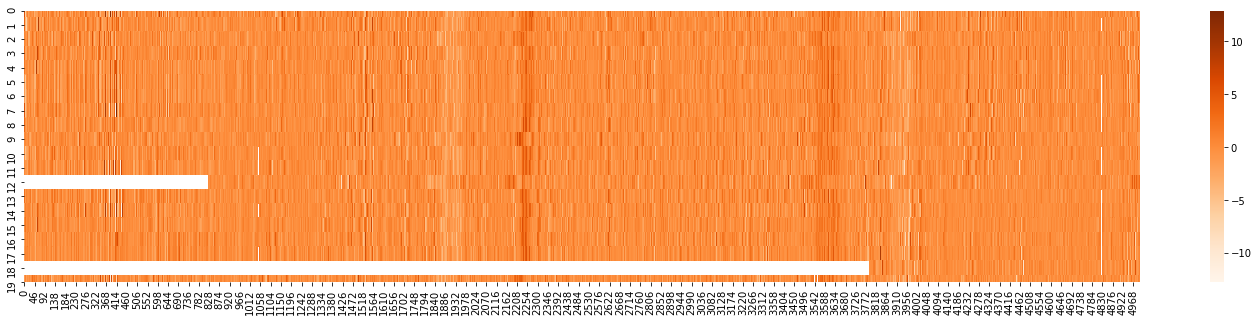

In [37]:
fig, ax = plt.subplots(figsize = (25,5))
ax = sns.heatmap(new_726001[new_726001['Measure']=='TW 3'].iloc[1000:6000, 1:-1].as_matrix().T, cmap = 'Oranges')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


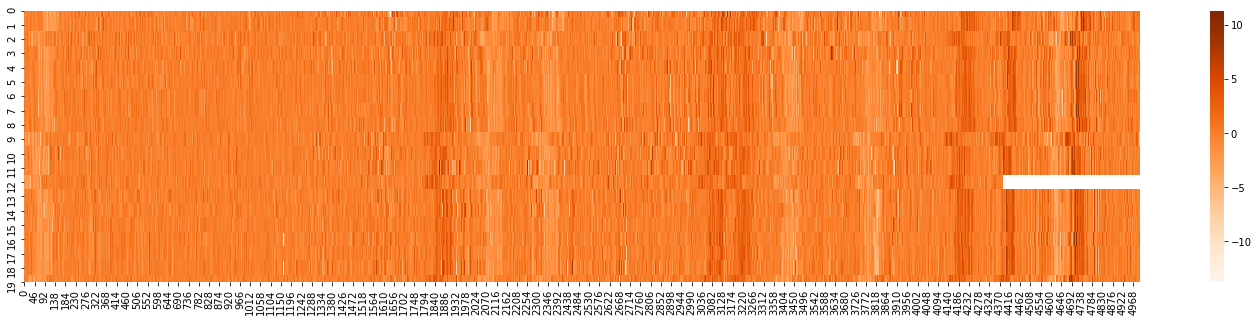

In [38]:
fig, ax = plt.subplots(figsize = (25,5))
ax = sns.heatmap(new_727001[new_727001['Measure']=='TW 3'].iloc[1000:6000, 1:-1].as_matrix().T, cmap = 'Oranges')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


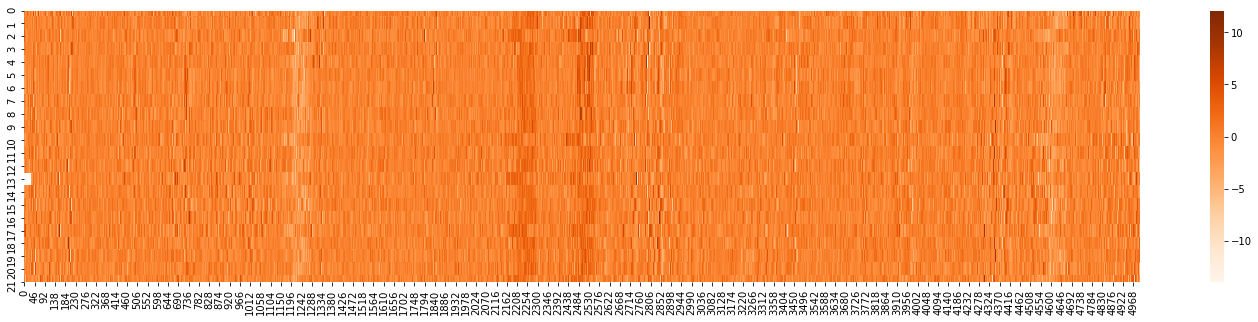

In [39]:
fig, ax = plt.subplots(figsize = (25,5))
ax = sns.heatmap(new_728001[new_728001['Measure']=='TW 3'].iloc[1000:6000, 1:-1].as_matrix().T, cmap = 'Oranges')

In [40]:
new_729001 = new_729001.iloc[:, 1:]

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


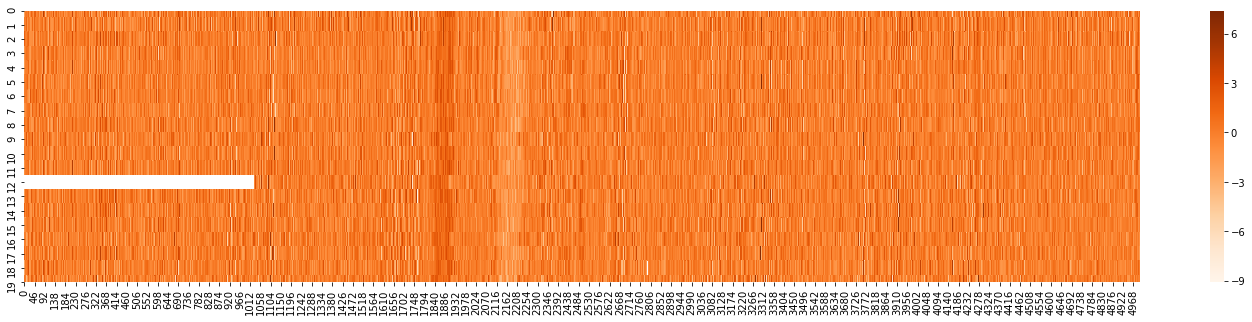

In [41]:
fig, ax = plt.subplots(figsize = (25,5))
ax = sns.heatmap(new_729001[new_729001['Measure']=='TW 3'].iloc[1000:6000, 1:-1].as_matrix().T, cmap = 'Oranges')

## Joining with work orders

In [4]:
trc_726 = pd.read_csv('aligned_726001.csv')
trc_727 = pd.read_csv('aligned_727001.csv')
trc_728 = pd.read_csv('aligned_728001.csv')
trc_729 = pd.read_csv('aligned_729001.csv')

In [5]:
def pivot_to_measure(df, track_code):
    cols = ['METRAGE','Measure', 'Date', 'Value']
    stacked = pd.DataFrame(df.set_index(['METRAGE', 'Measure']).stack()).reset_index()
    stacked.columns = cols
    pivoted = pd.pivot_table(stacked, index = ['METRAGE' , 'Date'], values='Value', columns = "Measure").reset_index()
    pivoted['Track_code'] = track_code
    return pivoted

In [6]:
df_726 = pivot_to_measure(trc_726, '726')

In [45]:
df_727 = pivot_to_measure(trc_727, '727')

In [46]:
df_728 = pivot_to_measure(trc_728, '728')

In [47]:
df_729 = pivot_to_measure(trc_729.iloc[:, 1:], '729')

In [10]:
## add GPS to TRC

In [28]:
import to_gps_coords

In [8]:
gps_df = pd.read_csv(os.path.join(paths.DATA_DERIVED, 'C138_C195_coords.csv'))


In [25]:
work_orders = pd.read_csv(os.path.join(paths.DATA_DERIVED, 'work_orders_with_track_code.csv'))

In [30]:
def extract_track_code(x):
    try: 
        ans = literal_eval(x)[0][:3]
    except:
        ans = ''
    return ans

work_orders['Track_code'] = work_orders['Track codes'].apply(lambda x: extract_track_code(x))

In [31]:
def match_work_orders(work_order, TRC, track_code):
    TRC['Date'] = pd.to_datetime(TRC['Date'])
    TRC['Work_orders'] = np.empty((len(TRC), 0)).tolist()
    TRC['Work_order_type'] = np.empty((len(TRC), 0)).tolist()
    
    datelist = sorted(TRC['Date'].unique(), reverse= True)
    w_o = work_order.loc[work_order['Track_code'] == track_code, :]
    w_o.loc[:, 'check_Date'] = pd.to_datetime(w_o['Bas. start date'])
    
    w_o['Date'] = np.empty((len(w_o), 0)).tolist()
    
    for date in datelist:
        w_o.loc[w_o['check_Date']> date, 'Date'].apply(lambda x: x.append(date))
    
    w_o.loc[:, 'Date'] = w_o['Date'].apply(lambda x: max(x))
    w_o.loc[:, 'Start Point'] = w_o['Start Point'].apply(lambda x: float(str(x).replace(',', '')))
    w_o.loc[:, 'End Point'] = w_o['End Point'].apply(lambda x: float(str(x).replace(',', '')))
    
    for i, workorder in w_o.iterrows():
        if len(TRC.loc[((TRC['Date'] == workorder['Date']) & (TRC['METRAGE'] >= workorder['Start Point']) & (TRC['METRAGE'] <= workorder['End Point']))]) == 0:
            print('No track found for {}'.format(workorder['Order']))
        TRC.loc[((TRC['Date'] == workorder['Date']) & (TRC['METRAGE'] >= workorder['Start Point']) & (TRC['METRAGE'] <= workorder['End Point'])), 'Work_orders'].apply(lambda x: x.append(workorder['Order']))
        TRC.loc[((TRC['Date'] == workorder['Date']) & (TRC['METRAGE'] >= workorder['Start Point']) & (TRC['METRAGE'] <= workorder['End Point'])), 'Work_order_type'].apply(lambda x: x.append(workorder['MAT descriptn']))
    TRC['Track_code'] = track_code
    return TRC

In [32]:
trcwo_726 = match_work_orders(work_orders, df_726, '726')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


No track found for 6100105463
No track found for 6100117423
No track found for 6100117424
No track found for 6100117425
No track found for 6100118188
No track found for 6100118189
No track found for 6100118190
No track found for 6100171701
No track found for 6100171702
No track found for 6100171703
No track found for 6100171704
No track found for 6100172821
No track found for 6100172822
No track found for 6100177068
No track found for 6100193872
No track found for 6100278251


In [14]:
trcwo_726.columns

Index(['METRAGE', 'Date', 'AC LN', 'AC VT', 'CON F', 'GAUGE', 'GR HT', 'OV HT',
       'SUPER', 'TOP L', 'TOP R', 'TR ST', 'TW 10', 'TW 3', 'VER L', 'VER R',
       'VOLT', 'Track_code', 'Work_orders', 'Work_order_type'],
      dtype='object', name='Measure')

In [21]:
len(trcwo_726[trcwo_726['Work_orders'].apply(lambda x:len(x))>0])

147708

In [57]:
trcwo_726.to_csv('trcwo726.csv')

In [58]:
trcwo_727 = match_work_orders(work_orders, df_727, '727')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


No track found for 6100133736
No track found for 6100148651
No track found for 6100163449
No track found for 6100163451
No track found for 6100163453
No track found for 6100173758
No track found for 6100174024
No track found for 6100174025
No track found for 6100179278
No track found for 6100186391


In [59]:
trcwo_728 = match_work_orders(work_orders, df_728, '728')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


No track found for 6100072314
No track found for 6100133737
No track found for 6100136637
No track found for 6100138874
No track found for 6100163455


In [60]:
trcwo_729 = match_work_orders(work_orders, df_729[df_729['Date']!= 'index'], '729')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


No track found for 6100034652
No track found for 6100081562
No track found for 6100133739
No track found for 6100157809
No track found for 6100163445
No track found for 6100163369
No track found for 6100164694
No track found for 6100164699
No track found for 6100142147
No track found for 6100170453
No track found for 6100171705
No track found for 6100171691
No track found for 6100171700
No track found for 6100205026
No track found for 6100212652
No track found for 6100222176
No track found for 6100212657
No track found for 6100196604
No track found for 6100228137
No track found for 6100240476
No track found for 6100229390
No track found for 6100229391
No track found for 6100283324
No track found for 6100302209


In [61]:
trcwo_726.to_csv('trcwo_726.csv', index = False)
trcwo_727.to_csv('trcwo_727.csv', index = False)
trcwo_728.to_csv('trcwo_728.csv', index = False)
trcwo_729.to_csv('trcwo_729.csv', index = False)

In [62]:
trcwo_726_gps =  Match_gps(gps_df, trcwo_726, '726').TRC_to_gps()

In [63]:
trcwo_727_gps =  Match_gps(gps_df, trcwo_727, '727').TRC_to_gps()

In [64]:
trcwo_728_gps =  Match_gps(gps_df, trcwo_728, '728').TRC_to_gps()

In [65]:
trcwo_729_gps =  Match_gps(gps_df, trcwo_729, '729').TRC_to_gps()

In [127]:
trcwo_726.shape[0] +trcwo_727.shape[0] +trcwo_728.shape[0] +trcwo_729.shape[0]

2988127

In [125]:
total_df.shape

(2988127, 22)

In [66]:
total_df = pd.concat([trcwo_726_gps,trcwo_727_gps,trcwo_728_gps, trcwo_729_gps])

In [67]:
total_df.to_csv('TRC_195_WO.csv', index = False)

# join in speed and culverts data

In [33]:
culvert = pd.read_csv(os.path.join(paths.DATA_DERIVED, 'culvert_crossing_with_track_codes.csv'))
speed = pd.read_csv(os.path.join(paths.DATA_DERIVED,'speed_and_curve_coord.csv' ))

In [22]:
def get_track_code(x):
    try:
        ans = x[0]
    except IndexError: #no track code
        ans = ''
    return ans

def simplify_track_code(df):
    df['Track codes'] = df['Track codes'].apply(lambda x: literal_eval(x))
    df['Track_code_pt1'] = df['Track codes'].apply(lambda x: get_track_code(x)[:3])
    df['Track_code_pt2'] = df['Track codes'].apply(lambda x: get_track_code(x)[3:])
    return df

In [23]:
culvert_2 = simplify_track_code(culvert)
speed_2 = simplify_track_code(speed)

In [35]:
def match_culvert(culvert_df, trc_df, track_code):
    filtered_culvert = culvert_df.loc[culvert_df['Track_code_pt1'] == track_code]
    print('found {} culverts to match'.format(len(filtered_culvert)))
    trc_df['culvert'] = 0
    for ind, row in filtered_culvert.iterrows():
        start = row['Start Point']
        end = row['End Point']
        trc_df.loc[trc_df['METRAGE'].between(start, end), 'culvert'] = 1
    return trc_df

In [44]:
def match_speed(speed_df, trc_df, track_code):
    filtered_speed = speed_df.loc[speed_df['Track_code_pt1'] == track_code]
    print('found {} speed rows to match'.format(len(filtered_speed)))
    collist = ['speed_description', 'speed_char_val_from', 'speed_char_val_to', 'speed_value_units']
    for col in collist:        
        trc_df[col] = np.nan
    for ind, row in filtered_speed.iterrows():
        start = row['Start Point']
        end = row['End Point']
        to_add = row[['Description', 'LAM Char. Val. From', 'LAM Char. Val. To', 'MU']]
        trc_df.loc[trc_df['METRAGE'].between(start, end),collist] = to_add
    return trc_df
        

In [46]:
## load trc data
trcwo_726 = pd.read_csv('trcwo_726.csv')
trcwo_727 = pd.read_csv('trcwo_727.csv')
trcwo_728 = pd.read_csv('trcwo_728.csv')
trcwo_729 = pd.read_csv('trcwo_729.csv')

In [47]:
trcwo_726_gps =  Match_gps(gps_df, trcwo_726, '726').TRC_to_gps()
trcwo_727_gps =  Match_gps(gps_df, trcwo_727, '727').TRC_to_gps()
trcwo_728_gps =  Match_gps(gps_df, trcwo_728, '728').TRC_to_gps()
trcwo_729_gps =  Match_gps(gps_df, trcwo_729, '729').TRC_to_gps()

In [48]:
## join culvert
trcwo_726_gps_culvert = match_culvert(culvert_2, trcwo_726_gps, '726')
trcwo_727_gps_culvert = match_culvert(culvert_2, trcwo_727_gps, '727')
trcwo_728_gps_culvert = match_culvert(culvert_2, trcwo_728_gps, '728')
trcwo_729_gps_culvert = match_culvert(culvert_2, trcwo_729_gps, '729')

found 161 culverts to match
found 42 culverts to match
found 22 culverts to match
found 204 culverts to match


In [49]:
trcwo_726_gps_culvert_speed = match_speed(speed_2, trcwo_726_gps, '726')
trcwo_727_gps_culvert_speed = match_speed(speed_2, trcwo_727_gps, '727')
trcwo_728_gps_culvert_speed = match_speed(speed_2, trcwo_728_gps, '728')
trcwo_729_gps_culvert_speed = match_speed(speed_2, trcwo_729_gps, '729')

found 0 speed rows to match
found 0 speed rows to match
found 0 speed rows to match
found 0 speed rows to match


In [50]:
# save individually and joined
trcwo_726_gps_culvert_speed.to_csv('trcwo_726_gps_culvert_speed.csv')
trcwo_727_gps_culvert_speed.to_csv('trcwo_727_gps_culvert_speed.csv')
trcwo_728_gps_culvert_speed.to_csv('trcwo_728_gps_culvert_speed.csv')
trcwo_729_gps_culvert_speed.to_csv('trcwo_729_gps_culvert_speed.csv')

In [51]:
total_df = pd.concat([trcwo_726_gps_culvert_speed, trcwo_727_gps_culvert_speed, trcwo_728_gps_culvert_speed, trcwo_729_gps_culvert_speed])
total_df.to_csv('C195_trc_gps_culvert_speed.csv')

In [13]:
fl = os.listdir(paths.TRC_138)[1:]

In [14]:
filedf = [] 

for f in fl:
    ans = dict()
    br = f.split('-')[:-1]
    ans['Track_ID']= br[0].replace(' ', '')
    ans['Description'] = '-'.join(br[1:-2])
    ans['Date'] = br[-1].replace(' ', '')[:8]
    ans['Recording_car']= br[-1].replace(' ','')[8:]
    ans['filename'] = f
    filedf.append(ans)

In [15]:
fdf = pd.DataFrame(filedf)

In [16]:
a = fdf[['Track_ID', 'Date','Recording_car']].groupby(['Track_ID','Date']).count()

In [10]:
dups = a[a['Recording_car']>1].reset_index()

In [11]:
dups

,Track_ID,Date,Recording_car
0,823301,20160909,3


In [15]:
to_combine = []
for ind, row in fdf.loc[(fdf['Track_ID'] == '823301') & (fdf['Date'] == '20160909')].iterrows():
    g = pd.read_csv(os.path.join(paths.TRC_138, row['filename']), skiprows = 4)
    to_combine.append(g)

combined = pd.concat(to_combine)

In [17]:
fdf.loc[(fdf['Track_ID'] == '823301') & (fdf['Date'] == '20160909')]

,Track_ID,Description,Date,Recording_car,filename
40,823301,UM 28.5-10.9 PETIRE,20160909,1251,823301 - UM 28.5-10.9 PETIRE-NORTHGATE - 20160...
45,823301,UM CONNECTION SPECIAL - N GATE,20160909,1315,823301 - UM CONNECTION SPECIAL - N GATE-VIRIGI...
60,823301,,20160909,1342,823301 - UM LAWNTON TO NORTHGATE - 20160909134...


In [16]:
combined.to_csv('823301 - nothing - 20160909 - FORMATTED.csv')

In [2]:
from join_trc import *

In [4]:
for ind, data in enumerate(final):
    data.to_csv('trc_138_joined_{}.csv'.format(ind))

In [4]:
aligned_df_dict = align_trc(paths.TRC_138, skip = 4).main_align()
final = []

wo_df = 'work_orders_with_track_code.csv'
gps_df = 'C138_C195_coords.csv'
culvert_df = 'culvert_crossing_with_track_codes.csv'
speed_df = 'speed_class_with_track_codes.csv'
for tcode, df in aligned_df_dict.items():
    joined = join_trc(df, wo_df,  gps_df, culvert_df, speed_df, tcode).main_join()
    final.append(joined)

Preparing list of files
prepared list of files
   Track_ID                 Description      Date Recording_car  \
0    823101      US 11.82-10.9 VIRGINIA  20161010          1159   
1    823101       US 11.9-10.9 VIRGINIA  20150515          1423   
2    823101       US 11.9-10.9 VIRGINIA  20180210          1557   
3    823101       US 11.9-10.9 VIRGINIA  20190206          1401   
4    823101       US 11.9-10.9 VIRGINIA  20171025          1259   
..      ...                         ...       ...           ...   
93   824301   UM D 50.8-28.5 CABOOLTURE  20160516          1116   
94   824301   UM D 50.8-29.1 CABOOLTURE  20170120          1228   
95   824301   UM D 50.8-29.1 CABOOLTURE  20170209          1157   
96   824301   UM D 50.8-29.1 CABOOLTURE  20170622          1124   
97   824301   UM D 50.8-29.1 CABOOLTURE  20180119          1107   

                                             filename  
0   823101 - US 11.82-10.9 VIRGINIA-NORTHGATE PLAT...  
1   823101 - US 11.9-10.9 VIRGINIA-N

ValueError: max() arg is an empty sequence

In [5]:
max([])

ValueError: max() arg is an empty sequence

In [7]:
final[0][final[0]['speed_description'].isna() == False]

Measure,METRAGE,Date,AC LN,AC VT,CON F,GAUGE,GR HT,OV HT,SUPER,TOP L,...,VER R,VOLT,Track_code,Work_orders,Work_order_type,culvert,speed_description,speed_char_val_from,speed_char_val_to,speed_value_units
668,10.951,2014-02-14,0.3,0.3,1.5,1082.5,-84.1,-207.5,-3.9,-0.3,...,4.0,0.8,823,[],[],0,SLEEPER TYPE,CONCRETE,NaN,NaN
669,10.951,2014-06-04,1.3,1.6,0.8,1063.5,7.3,-268.1,2.4,-4.6,...,38.5,-2.0,823,[],[],0,SLEEPER TYPE,CONCRETE,NaN,NaN
670,10.951,2014-10-31,0.1,1.0,1.8,1086.0,-9.5,-264.8,-36.5,-2.6,...,20.0,-33.8,823,[],[],0,SLEEPER TYPE,CONCRETE,NaN,NaN
671,10.951,2015-05-15,0.4,0.5,35.3,1066.0,-30.5,-270.4,5.0,-3.6,...,52.0,2.1,823,[],[],0,SLEEPER TYPE,CONCRETE,NaN,NaN
672,10.951,2015-10-02,0.8,0.4,22.0,1070.5,-17.4,-253.6,5.0,-1.9,...,53.5,-11.3,823,[],[],0,SLEEPER TYPE,CONCRETE,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15043,11.958,2014-10-31,0.1,1.1,-15.4,1067.0,0.0,-133.9,0.0,0.0,...,0.0,-33.8,823,[],[],1,SLEEPER TYPE,CONCRETE LOW PROFILE,NaN,NaN
15044,11.958,2017-10-25,1.1,1.3,-24.4,1065.5,0.9,-158.3,-0.6,-3.8,...,2.8,0.0,823,[],[],1,SLEEPER TYPE,CONCRETE LOW PROFILE,NaN,NaN
15045,11.959,2017-10-25,1.1,1.8,-15.6,1066.0,0.6,-156.4,-0.8,-2.9,...,3.0,0.0,823,[],[],1,SLEEPER TYPE,CONCRETE LOW PROFILE,NaN,NaN
15046,11.960,2017-10-25,1.4,0.6,-14.8,1066.5,0.5,-153.4,-0.5,-2.5,...,1.5,-0.1,823,[],[],1,SLEEPER TYPE,CONCRETE LOW PROFILE,NaN,NaN


In [5]:
pd.concat(final).to_csv('TRC_C138_combined.csv')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


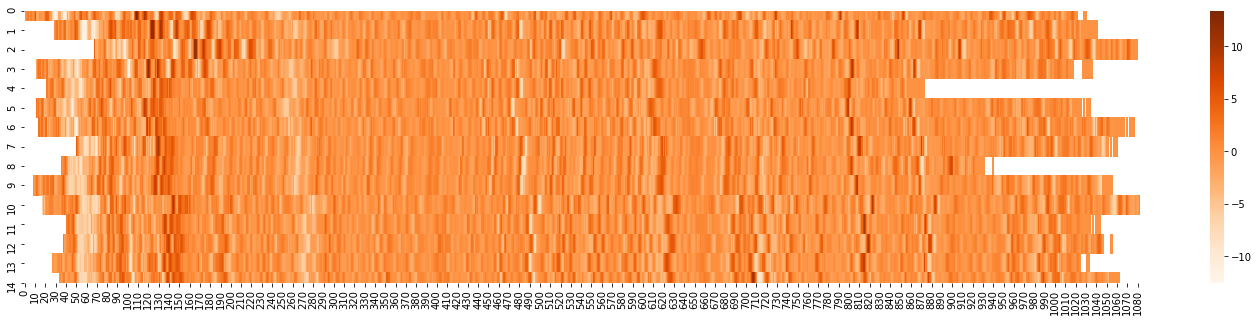

In [28]:

fig, ax = plt.subplots(figsize = (25,5))
ax = sns.heatmap(aligned_df_dict['823101'].loc[aligned_df_dict['823101']['Measure'] == 'TW 3'].iloc[:,1:-1].as_matrix().T, cmap = 'Oranges')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


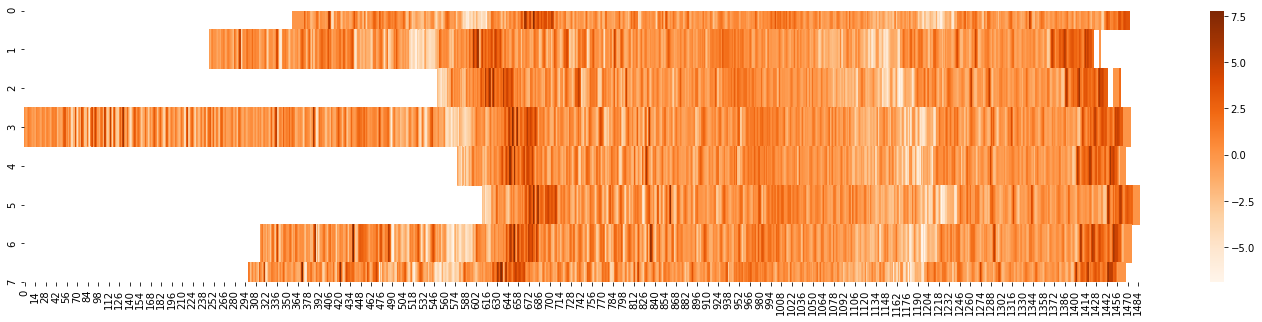

In [29]:

fig, ax = plt.subplots(figsize = (25,5))
ax = sns.heatmap(aligned_df_dict['823104'].loc[aligned_df_dict['823104']['Measure'] == 'TW 3'].iloc[:,1:-1].as_matrix().T, cmap = 'Oranges')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


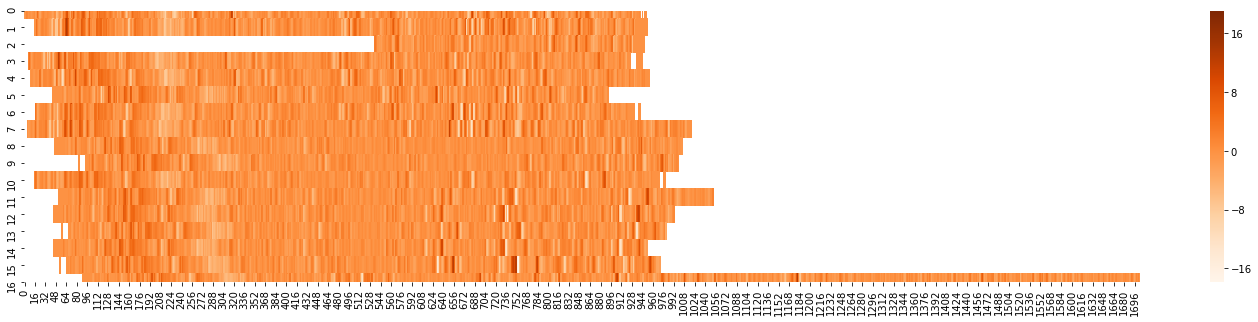

In [30]:

fig, ax = plt.subplots(figsize = (25,5))
ax = sns.heatmap(aligned_df_dict['823201'].loc[aligned_df_dict['823201']['Measure'] == 'TW 3'].iloc[:,1:-1].as_matrix().T, cmap = 'Oranges')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


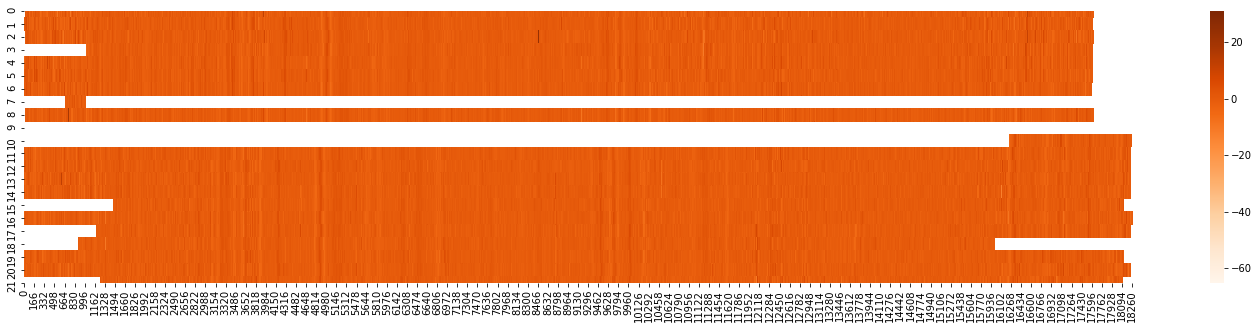

In [31]:

fig, ax = plt.subplots(figsize = (25,5))
ax = sns.heatmap(aligned_df_dict['823301'].loc[aligned_df_dict['823301']['Measure'] == 'TW 3'].iloc[:,1:-1].as_matrix().T, cmap = 'Oranges')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


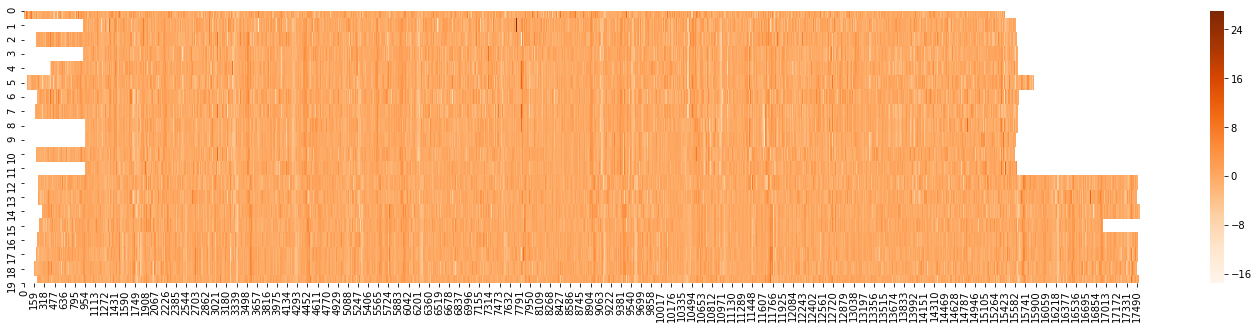

In [32]:

fig, ax = plt.subplots(figsize = (25,5))
ax = sns.heatmap(aligned_df_dict['823501'].loc[aligned_df_dict['823501']['Measure'] == 'TW 3'].iloc[:,1:-1].as_matrix().T, cmap = 'Oranges')

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


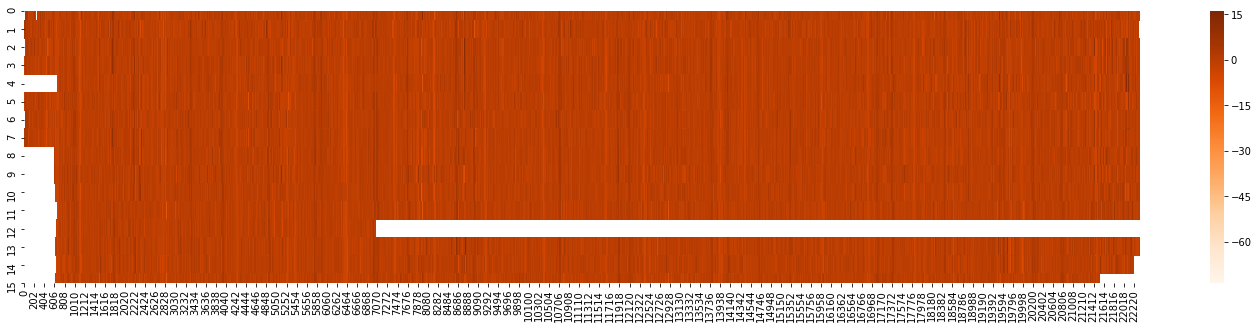

In [33]:

fig, ax = plt.subplots(figsize = (25,5))
ax = sns.heatmap(aligned_df_dict['824301'].loc[aligned_df_dict['824301']['Measure'] == 'TW 3'].iloc[:,1:-1].as_matrix().T, cmap = 'Oranges')

In [2]:
os.listdir('TRC_C138_combined')

['trc_138_joined_0.csv',
 'trc_138_joined_1.csv',
 'trc_138_joined_2.csv',
 'trc_138_joined_3.csv',
 'trc_138_joined_4.csv',
 'trc_138_joined_5.csv',
 'trc_138_joined_6.csv',
 'TRC_C138_combined.csv']

In [4]:
a = pd.read_csv(os.path.join('TRC_C138_combined', 'trc_138_joined_0.csv'))

In [5]:
a.columns

Index(['Unnamed: 0', 'METRAGE', 'Date', 'AC LN', 'AC VT', 'CON F', 'GAUGE',
       'GR HT', 'OV HT', 'SUPER', 'TOP L', 'TOP R', 'TR ST', 'TW 10', 'TW 3',
       'VER L', 'VER R', 'VOLT', 'Track_code', 'Work_orders',
       'Work_order_type', 'culvert', 'speed_description',
       'speed_char_val_from', 'speed_char_val_to', 'speed_value_units'],
      dtype='object')

In [7]:
a[a['speed_description'].isna() ==False]

,Unnamed: 0,METRAGE,Date,AC LN,AC VT,CON F,GAUGE,GR HT,OV HT,SUPER,...,VER R,VOLT,Track_code,Work_orders,Work_order_type,culvert,speed_description,speed_char_val_from,speed_char_val_to,speed_value_units


In [8]:
a[a['Work_orders'].isna() == False]

,Unnamed: 0,METRAGE,Date,AC LN,AC VT,CON F,GAUGE,GR HT,OV HT,SUPER,...,VER R,VOLT,Track_code,Work_orders,Work_order_type,culvert,speed_description,speed_char_val_from,speed_char_val_to,speed_value_units
0,0,10.880,2014-02-14,0.100000,0.100000,-8.100000,1073.500000,-13.800000,-306.000000,-36.10,...,25.300000,0.100000,823,[],[],0,NaN,NaN,NaN,NaN
1,1,10.881,2014-02-14,0.033333,0.033333,-2.683333,357.583333,-3.683333,-101.066667,-12.15,...,8.216667,0.016667,823,[],[],0,NaN,NaN,NaN,NaN
2,2,10.882,2014-02-14,0.100000,0.100000,-8.000000,1072.000000,-8.300000,-300.400000,-36.80,...,24.000000,0.000000,823,[],[],0,NaN,NaN,NaN,NaN
3,3,10.883,2014-02-14,0.100000,0.100000,-8.100000,1071.500000,-6.000000,-299.600000,-36.50,...,23.500000,-0.100000,823,[],[],0,NaN,NaN,NaN,NaN
4,4,10.884,2014-02-14,0.300000,0.100000,-8.400000,1070.000000,-3.400000,-298.800000,-38.80,...,23.500000,-0.100000,823,[],[],0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15043,15043,11.958,2014-10-31,0.100000,1.100000,-15.400000,1067.000000,0.000000,-133.900000,0.00,...,0.000000,-33.800000,823,[],[],1,NaN,NaN,NaN,NaN
15044,15044,11.958,2017-10-25,1.100000,1.300000,-24.400000,1065.500000,0.900000,-158.300000,-0.60,...,2.800000,0.000000,823,[],[],1,NaN,NaN,NaN,NaN
15045,15045,11.959,2017-10-25,1.100000,1.800000,-15.600000,1066.000000,0.600000,-156.400000,-0.80,...,3.000000,0.000000,823,[],[],1,NaN,NaN,NaN,NaN
15046,15046,11.960,2017-10-25,1.400000,0.600000,-14.800000,1066.500000,0.500000,-153.400000,-0.50,...,1.500000,-0.100000,823,[],[],1,NaN,NaN,NaN,NaN


In [12]:
for i, r in a.iloc[:10].iterrows():
    print(r[['Date', 'METRAGE']].tolist())

['2014-02-14', 10.88]
['2014-02-14', 10.880999999999998]
['2014-02-14', 10.882]
['2014-02-14', 10.883]
['2014-02-14', 10.884]
['2014-02-14', 10.885]
['2014-02-14', 10.886]
['2014-02-14', 10.887]
['2014-02-14', 10.888]
['2017-07-13', 10.888]


In [4]:
import pickle
gpr_pkl = open(os.path.join(paths.DATA, 'GPR_tmp.pkl'), 'rb')
gpr = pickle.load(gpr_pkl)
gpr_pkl.close()

In [5]:
gpr.head()

,Division,Sub-division,Line Segment,Track ID,Collection Date,GPR Run Number,Laser Run number,Start KM,End KM,Geolink,...,Right.4,Left*.5,Centre.5,Right*,Volume (cubic m),Category.3,Volume (cubic m).1,Category.4,Volume (cubic m).2,Category.5
0,Brisbane,XX,125,1,2015-05-26,1,1.2,0.0061,0.0011,geolink,...,1,3,3,3,0.553,5,-0.072,3,0.496,4
1,Brisbane,XX,125,1,2015-05-26,1,1.2,0.0112,0.0061,geolink,...,1,3,3,3,0.500,4,-0.078,3,0.028,3
2,Brisbane,XX,125,1,2015-05-26,1,1.2,0.0163,0.0112,geolink,...,1,3,3,3,0.525,5,-0.067,3,-0.044,3
3,Brisbane,XX,125,1,2015-05-26,1,1.2,0.0214,0.0163,geolink,...,1,3,3,3,0.667,5,0.003,3,0.380,4
4,Brisbane,XX,125,1,2015-05-26,1,1.2,0.0265,0.0214,geolink,...,1,3,3,3,0.765,5,-0.031,3,0.330,4


In [11]:
gpr[gpr['Line Segment']== 726]

,Division,Sub-division,Line Segment,Track ID,Collection Date,GPR Run Number,Laser Run number,Start KM,End KM,Geolink,...,Right.4,Left*.5,Centre.5,Right*,Volume (cubic m),Category.3,Volume (cubic m).1,Category.4,Volume (cubic m).2,Category.5


In [14]:
gpr_138 = pd.read_excel(os.path.join(paths.DATA_OCT, 'GPR Data for Corridor C138 Northgate to Caboolture.xlsx'), skiprows = 2)

In [18]:
gpr_138 = gpr_138.rename(columns = {'Unnamed: 50':'Mudspot'})

In [20]:
gpr_138_clean = gpr_138[[x for x in gpr_138.columns if 'Unnamed' not in x]]

In [21]:
gpr_138_clean.columns

Index(['Division', 'Sub-division', 'Line Segment', 'Track ID',
       'Collection Date', 'Start KM', 'End KM', 'Geolink', 'Dec.Lat',
       'Dec.Long', 'PVC Value', 'Category', 'PVC Value.1', 'Category.1',
       'PVC Value.2', 'Category.2', 'Left*', 'Centre', 'Right*', 'Left*.1',
       'Centre.1', 'Right*.1', 'Left*.2', 'Centre.2', 'Right*.2', 'Left*.3',
       'Centre.3', 'Right*.3', 'Volume (cubic m)', 'Category.3',
       'Volume (cubic m).1', 'Category.4', 'Volume (cubic m).2', 'Category.5',
       'Category.6', 'Category.7', 'Category.8', 'Left*.4', 'Right*.4',
       'Mudspot'],
      dtype='object')

In [44]:
gpr_195 = pd.read_excel(os.path.join(paths.DATA_OCT, 'GPR Data for NCL C195 Theebine to Bundaberg 2015.xlsx'), skiprows = 15)

In [45]:
gpr_195 = gpr_195.rename(columns = {'Unnamed: 53' : 'Mudspot', 'Unnamed: 57': 'Sleeper_type', 'Line Code' : 'Line Segment'})

In [46]:
gpr_195_clean = gpr_195[[x for x in gpr_195.columns if 'Unnamed' not in x]]

In [47]:
gpr_195_clean.columns

Index(['Division', 'Prefix', 'Line Segment', 'Track Code', 'Collection Date',
       'GPR Run Number', 'Laser Run number', 'Start KM', 'End KM', 'Geolink',
       'Dec.Lat', 'Dec.Long', 'PVC Value', 'Category', 'PVC Value.1',
       'Category.1', 'PVC Value.2', 'Category.2', 'Left*', 'Centre', 'Right',
       'Left*.1', 'Centre.1', 'Right.1', 'Left*.2', 'Centre.2', 'Right.2',
       'Left*.3', 'Centre.3', 'Right.3', 'Left*.4', 'Centre.4', 'Right*',
       'Left*.5', 'Centre.5', 'Right*.1', 'Volume (cubic m)', 'Category.3',
       'Volume (cubic m).1', 'Category.4', 'Volume (cubic m).2', 'Category.5',
       'Mudspot', 'Sleeper_type'],
      dtype='object')

In [48]:
gpr_195_138 = pd.concat([gpr_138_clean, gpr_195_clean])

j:\shared\omsa\sem3\dva\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [61]:
gpr_195_138 = gpr_195_138.drop('Track Code', axis = 1)

In [63]:
file = open('GPR_138_195.pickle', 'wb')
pickle.dump(gpr_195_138, file)
file.close()

In [64]:
gpr_195_138.head()

,Category,Category.1,Category.2,Category.3,Category.4,Category.5,Category.6,Category.7,Category.8,Centre,...,Right.1,Right.2,Right.3,Sleeper_type,Start KM,Sub-division,Track ID,Volume (cubic m),Volume (cubic m).1,Volume (cubic m).2
0,1,5,1,1,3,1,1.0,1.0,1.0,3,...,NaN,NaN,NaN,NaN,10.87900,NC,101.0,4.953,0.008,0.838
1,4,5,2,1,3,1,1.0,1.0,1.0,3,...,NaN,NaN,NaN,NaN,10.88402,NC,101.0,5.049,0.017,0.879
2,4,1,2,1,3,1,1.0,1.0,1.0,2,...,NaN,NaN,NaN,NaN,10.88904,NC,101.0,5.25,0.016,0.865
3,4,2,3,1,3,1,1.0,1.0,1.0,2,...,NaN,NaN,NaN,NaN,10.89406,NC,101.0,5.205,-0.040,0.775
4,2,1,1,1,3,1,1.0,1.0,1.0,2,...,NaN,NaN,NaN,NaN,10.89908,NC,101.0,5.061,-0.042,0.671


In [62]:
gpr_195_138.to_csv('gpr_195_138.csv', index = False)

In [52]:
gpr_195_138.shape

(47210, 52)

In [53]:
gpr_195_138.columns

Index(['Category', 'Category.1', 'Category.2', 'Category.3', 'Category.4',
       'Category.5', 'Category.6', 'Category.7', 'Category.8', 'Centre',
       'Centre.1', 'Centre.2', 'Centre.3', 'Centre.4', 'Centre.5',
       'Collection Date', 'Dec.Lat', 'Dec.Long', 'Division', 'End KM',
       'GPR Run Number', 'Geolink', 'Laser Run number', 'Left*', 'Left*.1',
       'Left*.2', 'Left*.3', 'Left*.4', 'Left*.5', 'Line Segment', 'Mudspot',
       'PVC Value', 'PVC Value.1', 'PVC Value.2', 'Prefix', 'Right', 'Right*',
       'Right*.1', 'Right*.2', 'Right*.3', 'Right*.4', 'Right.1', 'Right.2',
       'Right.3', 'Sleeper_type', 'Start KM', 'Sub-division', 'Track Code',
       'Track ID', 'Volume (cubic m)', 'Volume (cubic m).1',
       'Volume (cubic m).2'],
      dtype='object')

In [57]:
gpr_195_138['Track ID'].unique()

array([101., 201., 301., 401., 501.,  11.,  nan])

In [65]:
gpr_195_138.iloc[10, 12:15] = ['this', 'is','new']

In [66]:
gpr_195_138.iloc[10, 12:15] 

Centre.3    this
Centre.4      is
Centre.5     new
Name: 10, dtype: object

In [71]:
a = gpr_195_138.loc[gpr_195_138['Category'] == 4].index.tolist()

In [74]:
gpr_195_138.iloc[a, :][['Category', 'Centre.1']]

,Category,Centre.1
1,4,3
2,4,3
3,4,3
16,4,0
17,4,0
...,...,...
7040,6,0
7070,5,3
7081,5,3
7082,5,3


In [ ]:
['Category', 'Category.1', 'Category.2', 'Category.3', 'Category.4',
       'Category.5', 'Category.6', 'Category.7', 'Category.8', 'Centre',
       'Centre.1', 'Centre.2', 'Centre.3', 'Centre.4', 'Centre.5',
       'Collection Date','Division', 'GPR Run Number', 'Laser Run number', 'Left*', 'Left*.1',
       'Left*.2', 'Left*.3', 'Left*.4', 'Left*.5', 'Line Segment', 'Mudspot',
       'PVC Value', 'PVC Value.1', 'PVC Value.2', 'Prefix', 'Right', 'Right*',
       'Right*.1', 'Right*.2', 'Right*.3', 'Right*.4', 'Right.1', 'Right.2',
       'Right.3', 'Sleeper_type', 'Sub-division', 'Track Code',
       'Track ID', 'Volume (cubic m)', 'Volume (cubic m).1',
       'Volume (cubic m).2']